<a href="https://colab.research.google.com/github/kevinrosalesdev/SI-Practica2/blob/master/SI1_Practica_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 2: Desarrollo de arquitecturas NO supervisadas
## SOM usando Python y TensorFlow

Trabajo realizado por:
- Doramas Báez Bernal
- Marcos Jesús Santana Pérez
- Kevin Rosales Santana
- Borja Zarco Cerezo

Para el desarrollo de esta práctica se va a elaborar un SOM para, a través de tres preguntas elaboradas previamente sobre un *dataset* de la **Criminalidad de Chicago**, realizar un estudio de sus respuestas dada la distribución de conjuntos resultantes.

### *Imports* de librerías y del *dataset*
Se comprueba que el *dataset* está correctamente importado y que la versión de *TensorFlow* que se utiliza es la 1.15.

In [0]:
%tensorflow_version 1.x

from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf

drive.mount('/content/drive', force_remount=True)

print("\nDataset Location: ")
!ls "/content/drive/My Drive/Colab Notebooks/Sistemas inteligentes/KOHONEN/Criminalidad_Chicago_2018.csv"

print("\nTensorFlow Version: ")
!pip list | grep tensorflow
print(tf.__version__)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive

Dataset Location: 
'/content/drive/My Drive/Colab Notebooks/Sistemas inteligentes/KOHONEN/Criminalidad_Chicago_2018.csv'

TensorFlow Version: 
mesh-tensorflow          0.1.7      
tensorflow               1.15.0     
tensorflow-datasets      1.3.2      
tensorflow-estimator     1.15.1     
tensorflow-gan           2.0.0      
tensorflow-hub           0.7.0      
tensorflow-metadata      0.15.1     
tensorflow-privacy       0.2.2      
tensorflow-probability  

## Tratamiento inicial del *Dataset*: carga de datos y limpieza preliminar

En primer lugar, cargaremos el dataset a partir de un *.csv* y mostraremos el mismo. Haremos una **limpieza preliminar de los datos**, transformando aquellos valores que consideremos categóricos a un formato adecuado para poder realizar un análisis de los datos lo mejor posible.


### Paso 1: Carga de datos

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sistemas inteligentes/KOHONEN/Criminalidad_Chicago_2018.csv', na_values=[' '])
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)
original_dataset = dataset.copy()

print("Dataset before modifications: ")
dataset

Dataset before modifications: 


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11436011,JB421759,09/02/2018 12:00:00 AM,038XX W 76TH PL,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,RESIDENCE,False,False,833,8,18.0,70.0,11,1151769.0,1853644.0,2018,09/09/2018 03:57:45 PM,41.754268,-87.719388,"(41.75426822, -87.719388112)"
1,11435990,JB421666,09/02/2018 02:00:00 AM,002XX W 108TH ST,0890,THEFT,FROM BUILDING,RESIDENCE,False,False,513,5,34.0,49.0,06,1176509.0,1833320.0,2018,09/09/2018 03:57:45 PM,41.697976,-87.629333,"(41.697976242, -87.629333075)"
2,11435976,JB421557,09/02/2018 07:26:00 PM,044XX S FRANCISCO AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,False,922,9,14.0,58.0,26,1157773.0,1875116.0,2018,09/09/2018 03:57:45 PM,41.813071,-87.696803,"(41.813070769, -87.696802646)"
3,11435964,JB421634,09/02/2018 12:00:00 PM,070XX S CLYDE AVE,0820,THEFT,$500 AND UNDER,STREET,False,False,331,3,5.0,43.0,06,1191428.0,1858720.0,2018,09/09/2018 03:57:45 PM,41.767329,-87.573888,"(41.767328645, -87.573887599)"
4,11435957,JB421387,09/02/2018 05:24:00 PM,038XX N NARRAGANSETT AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,CEMETARY,False,False,1632,16,38.0,17.0,14,1133028.0,1924670.0,2018,09/09/2018 03:57:45 PM,41.949521,-87.786412,"(41.949520997, -87.786411512)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176644,23762,JB105277,01/06/2018 12:54:00 PM,015XX E 62ND ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,314,3,5.0,42.0,01A,1187318.0,1864355.0,2018,01/13/2018 03:51:44 PM,41.782890,-87.588773,"(41.782890153, -87.588773433)"
176645,23763,JB105765,01/05/2018 06:50:00 PM,053XX W LAKE ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,1523,15,28.0,25.0,01A,1140721.0,1902054.0,2018,01/12/2018 03:58:33 PM,41.887322,-87.758690,"(41.887322035, -87.758689717)"
176646,23759,JB100839,01/01/2018 06:27:00 PM,047XX S PRINCETON AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,935,9,3.0,37.0,01A,1175089.0,1873464.0,2018,01/08/2018 03:55:29 PM,41.808168,-87.633336,"(41.808168003, -87.633336457)"
176647,23758,JB100522,01/01/2018 11:33:00 AM,026XX N HAMPDEN CT,0110,HOMICIDE,FIRST DEGREE MURDER,APARTMENT,False,False,1935,19,43.0,7.0,01A,1172664.0,1917743.0,2018,01/08/2018 03:55:29 PM,41.929727,-87.640921,"(41.929726567, -87.64092074)"


### Paso 2: Transformación de datos categóricos o de tipo *string* a numérico
Como ya se ha comentado en la Actividad Práctica anterior, resulta importante a la hora de estudiar un *dataset* **tratar de evitar el uso de datos de tipo *string* o categóricos** para ayudar al entendimiento del Sistema Inteligente de los datos entrantes.

In [0]:
print("Data types before transformations:")
print(dataset.dtypes)

categorical_cols = [
    'Location Description',
    'FBI Code',
    'IUCR',
    'Block'
]

for col in categorical_cols:
  dataset[col] = dataset[col].astype('category').cat.codes

print("\nData types after transformations:")
print(dataset.dtypes)

Data types before transformations:
ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

Data types after transformations:
ID                        int64
Case Number              object
Date                     object
Block                     int16
IUCR                      int16
Primary Type             object
Description         

### Paso 3: Transformación de datos temporales a tipo numérico
En esta ocasión, optamos por recoger los datos de las horas, el día de la semana y el mes de cada uno de los registros porque consideramos que eran los relevantes a la hora de obtener la distribución deseada.

En otras palabras, **no consideramos que los minutos ni los segundos ni el día del mes fueran importantes** para responder a cualquier pregunta de la Actividad Práctica planteada a través del SOM.

In [0]:
hour = []
weekday = []
month = []

for date_str in dataset.Date:
  my_date = datetime.strptime(date_str, "%m/%d/%Y %I:%M:%S %p")
  hour.append(my_date.hour)
  weekday.append(my_date.weekday())
  month.append(my_date.month)
    
dataset["Hour"] = hour
dataset["Weekday"] = weekday
dataset["Month"] = month
dataset = dataset.drop("Date", axis=1)

print("Dataset after modifications:")
dataset

Dataset after modifications:


,ID,Case Number,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Hour,Weekday,Month
0,11436011,JB421759,13398,113,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,96,False,False,833,8,18.0,70.0,13,1151769.0,1853644.0,2018,09/09/2018 03:57:45 PM,41.754268,-87.719388,"(41.75426822, -87.719388112)",0,6,9
1,11435990,JB421666,1181,83,THEFT,FROM BUILDING,96,False,False,513,5,34.0,49.0,7,1176509.0,1833320.0,2018,09/09/2018 03:57:45 PM,41.697976,-87.629333,"(41.697976242, -87.629333075)",2,6,9
2,11435976,JB421557,14813,244,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,96,False,False,922,9,14.0,58.0,25,1157773.0,1875116.0,2018,09/09/2018 03:57:45 PM,41.813071,-87.696803,"(41.813070769, -87.696802646)",19,6,9
3,11435964,JB421634,20804,77,THEFT,$500 AND UNDER,111,False,False,331,3,5.0,43.0,7,1191428.0,1858720.0,2018,09/09/2018 03:57:45 PM,41.767329,-87.573888,"(41.767328645, -87.573887599)",12,6,9
4,11435957,JB421387,13257,133,CRIMINAL DAMAGE,TO PROPERTY,30,False,False,1632,16,38.0,17.0,16,1133028.0,1924670.0,2018,09/09/2018 03:57:45 PM,41.949521,-87.786412,"(41.949520997, -87.786411512)",17,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176644,23762,JB105277,5716,0,HOMICIDE,FIRST DEGREE MURDER,111,False,False,314,3,5.0,42.0,0,1187318.0,1864355.0,2018,01/13/2018 03:51:44 PM,41.782890,-87.588773,"(41.782890153, -87.588773433)",12,5,1
176645,23763,JB105765,17307,0,HOMICIDE,FIRST DEGREE MURDER,111,False,False,1523,15,28.0,25.0,0,1140721.0,1902054.0,2018,01/12/2018 03:58:33 PM,41.887322,-87.758690,"(41.887322035, -87.758689717)",18,4,1
176646,23759,JB100839,15572,0,HOMICIDE,FIRST DEGREE MURDER,21,False,False,935,9,3.0,37.0,0,1175089.0,1873464.0,2018,01/08/2018 03:55:29 PM,41.808168,-87.633336,"(41.808168003, -87.633336457)",18,0,1
176647,23758,JB100522,9593,0,HOMICIDE,FIRST DEGREE MURDER,17,False,False,1935,19,43.0,7.0,0,1172664.0,1917743.0,2018,01/08/2018 03:55:29 PM,41.929727,-87.640921,"(41.929726567, -87.64092074)",11,0,1


## Análisis de Componentes Principales (PCA)

Antes de implementar cualquier técnica de aprendizaje, nos centraremos en **el tratamiento y análisis de los datos.**

Usaremos otras técnicas de visualización y análisis de los datos como la matriz de correlación.


### Paso 1: Análisis de la correlación
Resulta vital para conocer la relación entre los datos **procesar una matriz de correlación.** De esta manera, se puede observar qué campos son los que se encuentran relacionados entre sí y qué campo (y su relevancia) en el *dataset* deberíamos analizar.

Correlation Matrix:


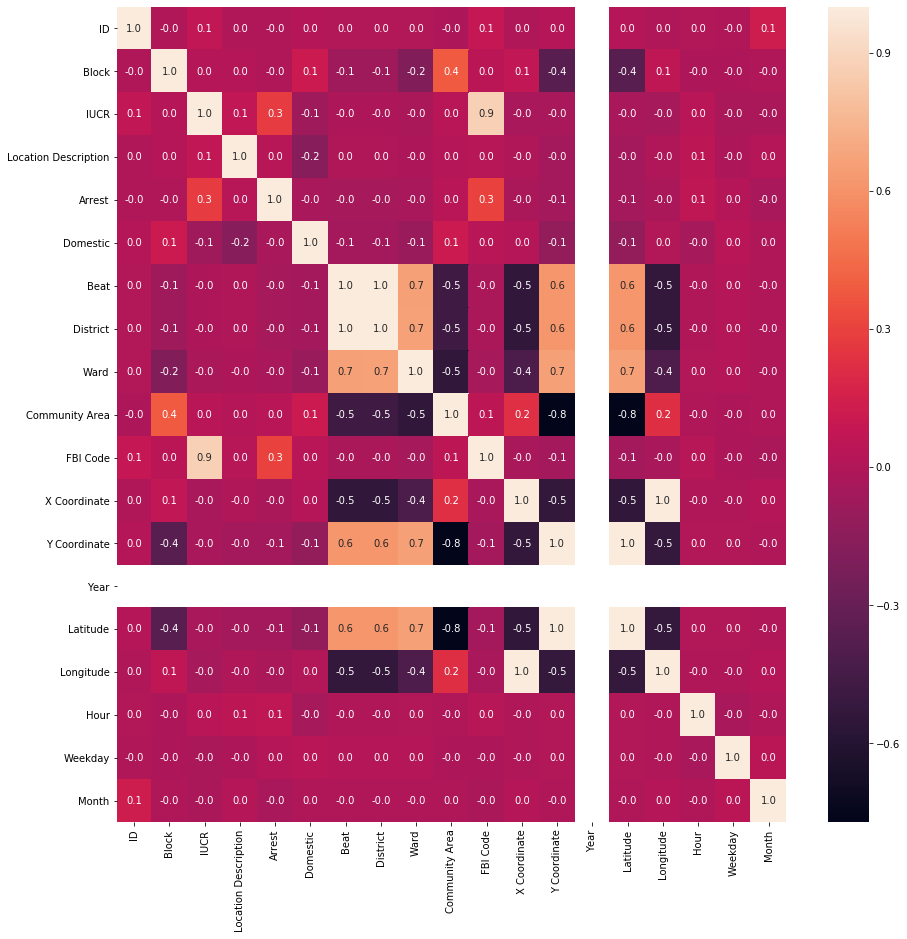

In [0]:
corr = dataset.corr()
plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.1f')
print("Correlation Matrix:")

### Paso 2: Descartar datos relacionados o innecesarios

Tras un primer analisis visual, se ha apreciado que hay datos que representan exactamente lo mismo o datos que son innecesarios de cara a la distinción de clases para una IA. Por ello, decidimos descartar las siguientes columnas:

- Las columnas *Primary Type* y *Description* están representadas por el *IUCR*. Por ello, estas columnas se eliminan. Tras un breve estudio, se conoce que se trata del código que utiliza la policía de Illinois para referenciar un tipo concreto de crimen. 

  - Por ejemplo, en el caso de los últimos registros, 'HOMICIDE' como *Primary Type* y 'FIRST DEGREE MURDER' como *Description* dan lugar al mismo *IUCR*. Esto se repite a lo largo del *Dataset*. 

  - Además, un mismo *Primary Type* da lugar a *IUCR* cercanos.

  - Y un mismo *Description* pertenece únicamente a un *Primary Type*.

- La columna *ID* es innecesaria para extraer conclusiones por parte de la red, pues solo representa un delito (un registro dentro del propio *dataset*). Por este razonamiento, es eliminada.

- La columna *Case Number* tambien es innecesaria porque se trata de una identificación y no aporta ninguna característica. Por este motivo, se elimina. Además, se ha descubierto que los casos (un porcentaje muy pequeño del *dataset*) que tienen múltiples crímenes tienen dos crímenes asociados.

- La columna *Location* se elimina debido a que ya se tiene separada en el *dataset* con la columna *Latitude* y *Longitude*.
    - Es cierto que estas dos últimas columnas tienen menos precisión que la columna *Location*, pero no se consideró que fuera vital ese rango de precisión.

- La columna *Year* no tiene ninguna utilidad debido a que todos los casos transcurren en 2018. Por ello, la columna se elimina.

- La columna *Updated On* tampoco resulta de utilidad a la hora de investigar cómo se puede distribuir un *SOM* tras cuestionarse cualquier pregunta sobre los crímenes dado a que cuándo se actualizó un determinado registro en el *dataset* no tiene importancia, por lo que se elimina.

- Además, se tiene que las columnas *X Coordinate* e *Y Coordinate* carecen de importancia debido a que representan el mismo dato que las columnas *Latitude* y *Longitude* (y que, evidentemente, *Location*). Por este motivo, también son eliminadas.

Sin embargo, las columnas *District*, *Community Area* y *Block* pueden ser muy relevantes a la hora de responder a determinadas preguntas con el *SOM* sobre la localización de los crímenes. 

La columna *FBI Code* es otra representación del *IUCR*, pero se mantiene por si se quiere realizar preguntas sobre la distribución de estas identificaciones. 

La columna *Beat* (Ronda del oficial de policía) está directamente relacionada con la columna *District* (Distrito), pero se mantiene por el mismo motivo que las columnas *FBI Code* e *IUCR* (por si se requiere para futuras preguntas).


In [0]:
useless_cols = [
    'Primary Type',
    'Description',
    'ID',
    'Case Number',
    'Location',
    'Year',
    'Updated On',
    'X Coordinate',
    'Y Coordinate'
]
print("[Study of Rows and IDs]")
print("Number of Rows in Dataset: ", len(dataset))
print("Number of IDs: ", len(dataset.ID.unique()))

print("\n[Study of Crimes and Case Numbers]")
print("Number of crimes: ", len(dataset.IUCR.unique()))
print("Cases with multiple crimes associated: ", len(dataset) - len(dataset['Case Number'].unique()))
print("Crimes related to cases with multiple crimes associated: ", len(dataset[dataset.duplicated(subset=['Case Number'], keep=False)]))

print("\n[Study of Blocks, Community Areas and Districts]")
print("Number of Blocks: ", len(dataset.Block.unique()))
print("Number of Community Areas: ", len(dataset['Community Area'].unique()))
print("Number of Districts: ", len(dataset.District.unique()))

for cols in useless_cols:
  dataset = dataset.drop(cols, axis=1)

[Study of Rows and IDs]
Number of Rows in Dataset:  176649
Number of IDs:  176649

[Study of Crimes and Case Numbers]
Number of crimes:  310
Cases with multiple crimes associated:  14
Crimes related to cases with multiple crimes associated:  28

[Study of Blocks, Community Areas and Districts]
Number of Blocks:  25508
Number of Community Areas:  77
Number of Districts:  23


### Paso 3: Comprobar la nueva correlación entre los datos

Tras eliminar todas las columnas innecesarias (aportando motivos para despreciarlas), se vuelve a dibujar la **matriz de correlación**:

Correlation Matrix:


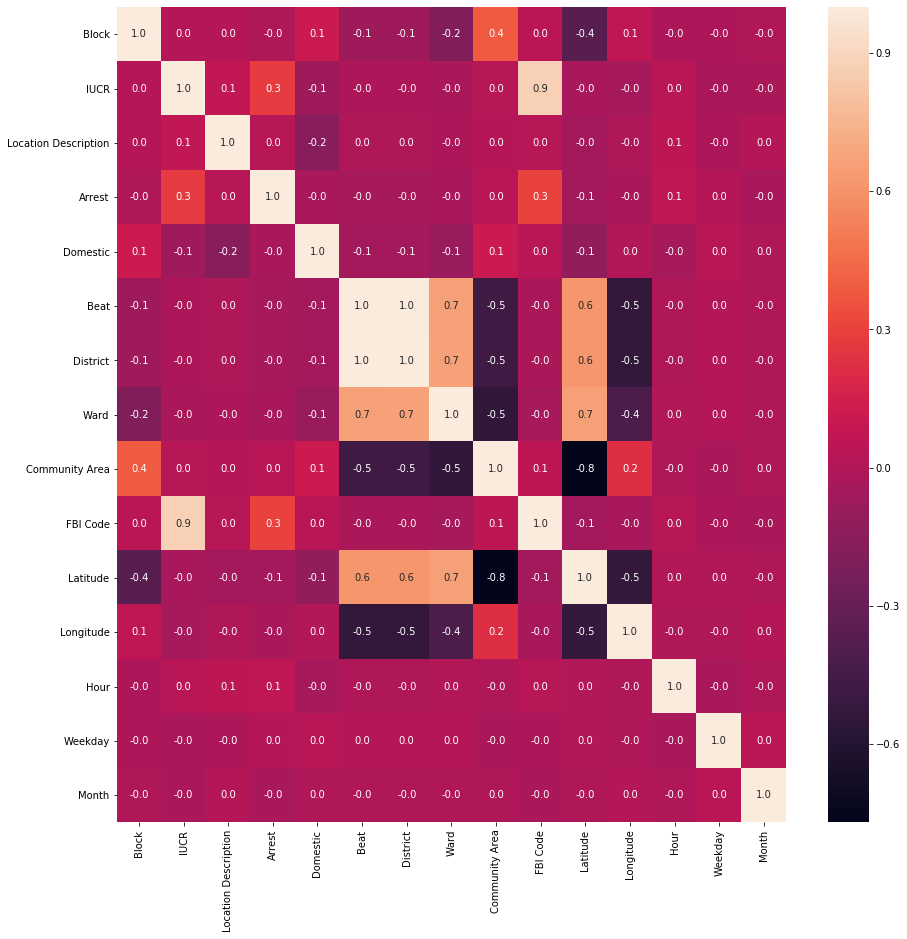

In [0]:
corr = dataset.corr()
f,ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt='.1f')
print("Correlation Matrix:")

In [0]:
print("Dataset after correlation matrix study:")
dataset

Dataset after correlation matrix study:


,Block,IUCR,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude,Hour,Weekday,Month
0,13398,113,96,False,False,833,8,18.0,70.0,13,41.754268,-87.719388,0,6,9
1,1181,83,96,False,False,513,5,34.0,49.0,7,41.697976,-87.629333,2,6,9
2,14813,244,96,False,False,922,9,14.0,58.0,25,41.813071,-87.696803,19,6,9
3,20804,77,111,False,False,331,3,5.0,43.0,7,41.767329,-87.573888,12,6,9
4,13257,133,30,False,False,1632,16,38.0,17.0,16,41.949521,-87.786412,17,6,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176644,5716,0,111,False,False,314,3,5.0,42.0,0,41.782890,-87.588773,12,5,1
176645,17307,0,111,False,False,1523,15,28.0,25.0,0,41.887322,-87.758690,18,4,1
176646,15572,0,21,False,False,935,9,3.0,37.0,0,41.808168,-87.633336,18,0,1
176647,9593,0,17,False,False,1935,19,43.0,7.0,0,41.929727,-87.640921,11,0,1


## Implementación de un SOM

Se ha considerado que es más sencillo implementar **un primer SOM** para tener el algoritmo ya implementado y así únicamente tener que preocuparse en los siguientes pasos de estudiar las hipótesis correctas modificando las entradas apropiadas.



### Paso 1: Uso de un Dummy *Dataset* para el testeo

Para implementar el **SOM** vamos a usar un dataset de colores, para que los resultados queden visibles.

Para ello, se ha decodificado los distintos colores *RGB* con el fin de que el SOM pueda clasificar correctamente los distintos grupos.

In [0]:
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']

### Paso 2: Implementacion del SOM

Se ha usado **el algoritmo explicado en la [Wikipedia](https://en.wikipedia.org/wiki/Self-organizing_map)**.

Variables utilizadas:
```
dim = dimensión del problema.
m = número de filas de neuronas del tensor del mapa.
n = número de columnas de neuronas del tensor del mapa.
nfr = sigma.
learning_rate = tasa de aprendizaje.
learning = función de learning_rate (lineal). 
epochs = iteraciones.
epoch = iteración actual.
node_indexes = localizaciones de las neuronas.
nodes = neuronas (sus pesos).
input_data = datos de entrada.
training = nodos tras la asignación de sus nuevos pesos.
_som = grafo (tensor SOM).
_session = sesión de TensorFlow.
```


In [0]:
class SOM(object):
  def __init__(self, m, n, dim, nfr=None, learning_rate=0.85, epochs=5):
    self.m = m
    self.n = n
    self.dim = dim
    self.epochs = epochs
    
    self._som = tf.Graph()
    with self._som.as_default():
      self.learning_rate = tf.constant(learning_rate, dtype=tf.float32, name="lr")
      if nfr == None:
          self.nfr = tf.constant(np.array([max(self.m, self.n) / 2]), dtype=tf.float32) 
      else:
          self.nfr = tf.constant(np.array(nfr), dtype=tf.float32)
      
      # Variables / Constants
      total_epochs = tf.constant(np.array(self.epochs), dtype=tf.float32)
      two = tf.constant(np.array(2), dtype=tf.float32)
      self.node_indexes = tf.constant(self._neuron_locations(), name='node_indexes')
      self.nodes = tf.Variable(tf.random_normal([m * n, dim]), name='nodes')
      
      # Placeholders
      self.input_data = tf.placeholder(dtype=tf.float32, shape=[self.dim], name='input_data')

      # Operations
      self.epoch = tf.placeholder("float")
      self.learning = tf.multiply(self.learning_rate, tf.divide(tf.constant(1.0, dtype=tf.float32), self.epoch))
      error = tf.subtract(self.input_data, self.nodes)

      eucledian_distance = tf.norm(error, axis=1)
      bmu = tf.reduce_min(eucledian_distance, axis=0)
      bmu_index = self.node_indexes[tf.compat.v2.where(tf.equal(eucledian_distance, bmu))[0, 0], :]
      index_distance = tf.norm(tf.subtract(tf.cast(bmu_index, dtype=tf.float32), self.node_indexes), axis=1)
      neighbour_radius = tf.multiply(self.nfr, tf.exp(tf.math.negative(tf.divide(self.epoch, total_epochs))))
      numerator = tf.math.negative(tf.pow(index_distance, two))
      denominator = tf.multiply(two, tf.pow(neighbour_radius, two))
      n_func = tf.multiply(self.learning, tf.exp(tf.divide(numerator, denominator)))
      
      ones = tf.ones([1,self.dim], dtype=tf.float32)
      n_func = tf.matmul(tf.reshape(n_func, shape=[self.m*self.n, 1]), ones)
      delta_nodes = tf.multiply(n_func, tf.multiply(self.learning, error))
      new_nodes = tf.add(self.nodes, delta_nodes)
      self.training = tf.assign(self.nodes, new_nodes)
      self._session = tf.Session()
      init_op = tf.global_variables_initializer()
      self._session.run(init_op)
        
        
  def train(self, input_df, size_per_epoch=np.inf):
    self.errors = []
    randomize = np.arange(len(input_df)) #[0 1 2 3 4 .. input_df]
    if size_per_epoch > len(input_df):
      size_per_epoch = len(input_df)
    for t in range(0, self.epochs):
      np.random.shuffle(randomize) #[1 3 5 0 .. 2]
      for data in input_df[randomize[:size_per_epoch]]: # data in input_df[[1 3 5 0 .. size_per_epoch]
        self._session.run(self.training, 
                          feed_dict={
                            self.input_data: data,
                            self.epoch: t+1
                          })
      error = self.get_error(input_df[randomize[:size_per_epoch]])
      self.errors.append(error)
      print("\rIteracion %s: SSE: %f\t\t\t" % (t, error), end='')
        
  def predict(self, input_vects):
    res = []
    for vec in input_vects:
      min_index = min([i for i in range(len(self.weights))], key=lambda x:np.linalg.norm(vec - self.weights[x]))
      res.append(self._neuron_locations()[min_index])
    return res

  def _neuron_locations(self):
    return np.array([[i, j] for i in range(self.m) for j in range(self.n)], dtype=np.float32)

  def get_clusters(self):
    clusters = [[] for i in range(self.m)]
    self.weights = self._session.run(self.nodes)
    for i, loc in enumerate(self._neuron_locations()):
      clusters[int(loc[0])].append(self.weights[i])
    return clusters
  
  def get_error(self, input_vectors):
    image_grid = self.get_clusters()
    mapped = self.predict(input_vectors)
    subtracts = [np.subtract(input_vectors[i],image_grid[int(mapped[i][0])][int(mapped[i][1])]) for i in range(len(input_vectors))]
    norm = [np.linalg.norm(subtracts[i]) for i in range(len(input_vectors))]
    return np.sum(norm)/len(input_vectors)




In [0]:
som = SOM(40, 40, 3, learning_rate=0.85, epochs=5)
som.train(colors)


Iteracion 4: SSE: 0.329467			

### Paso 3: Entrenamiento y Resultados

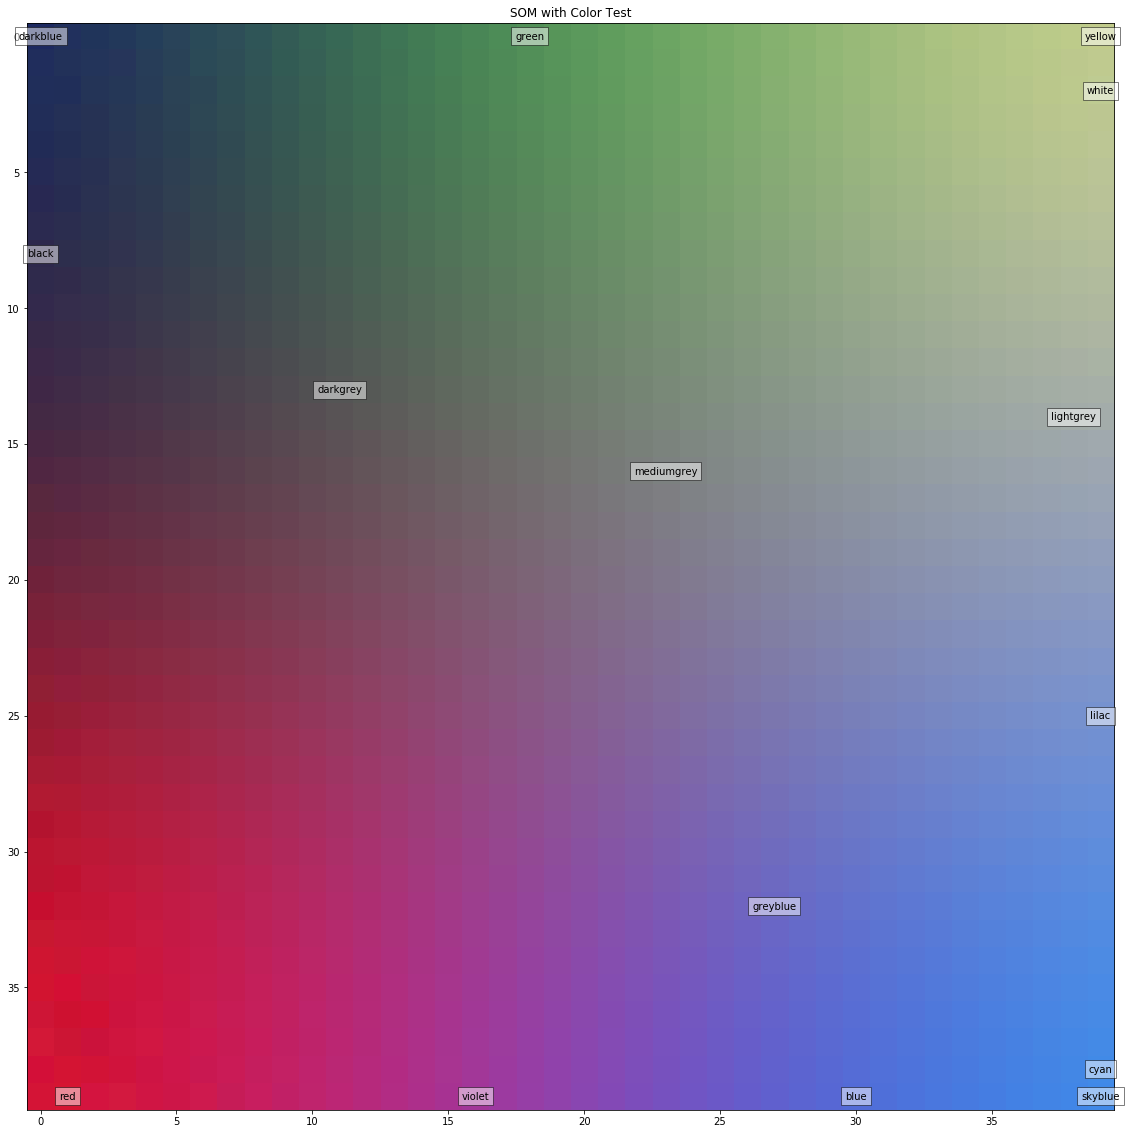

In [0]:
image_grid = som.get_clusters()
mapped = som.predict(colors)
plt.figure(figsize=(20,20))
plt.imshow(image_grid)
plt.title('SOM with Color Test')
for i, c in enumerate(mapped):
  plt.text(c[1], c[0], color_names[i], ha = 'center', va='center', bbox=dict(facecolor='white', alpha=0.5, lw=1))
plt.show()

### Paso 4: Cálculo del Error
Para ver la evolución que ha tenido el entrenamiento del SOM, **visualizamos el error**. Dicho error es calculado en cada iteración como la suma de las normas de la diferencia del vector entrante (registro/fila del *dataset*) y el peso del nodo al que se le asigne entre el número de muestras. Es decir:

Error = $ \frac{\sum_{i=0}^{N} \lVert x_{i} - w^c_{i}\rVert}{N} $

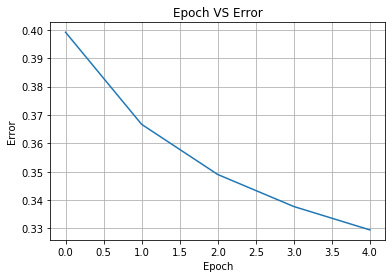

In [0]:
  plt.figure('Error Progress')
  plt.plot(list(range(0, som.epochs)), som.errors)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.grid(True)
  plt.title('Epoch VS Error')
  plt.show()

## Análisis de las hipótesis
Llegados a este punto, ya hemos realizado el tratamiento del dataset, eliminando las filas que aportaban la misma información. Además, hemos realizado una primera implementacion del mapa SOM utilizando como dataset colores. Como se ha podido comprobar previamente obtenemos unos resultados bastante buenos para el dataset de colores.

Por ello, a continuación se tratará de responder a **tres preguntas relacionadas con el *dataset*** de **Criminalidad de Chicago respecto a la distribución resultante del *SOM***.


## Estudio 1:

### Hipótesis
**¿Cómo se relaciona si ha habido arresto y si es domiciliario con los distritos?**

En este apartado hemos querido poder conocer cómo es **la distribución arresto/crimen doméstico** con respecto a unas zonas que son los distritos. Es decir, poder observar en qué distrito se producen **más arrestos domésticos** y así, **deducir cuáles son los distritos más seguros.**



In [0]:
hipotesis3 = dataset[['District', 'Arrest', 'Domestic']]
hipotesis3

,District,Arrest,Domestic
0,8,False,False
1,5,False,False
2,9,False,False
3,3,False,False
4,16,False,False
...,...,...,...
176644,3,False,False
176645,15,False,False
176646,9,False,False
176647,19,False,False


In [0]:
crime_som3 = SOM(50, 50, hipotesis3.shape[1], learning_rate=0.85, epochs=50)
crime_som3.train(hipotesis3.to_numpy(), size_per_epoch=500)

Iteracion 49: SSE: 0.724443			

#### Visualización de los grupos
Para comprobar que el mapa *SOM* clasifica correctamente, se va a mostrar en dicho mapa un *dataset* con todas las posibles muestras. 

In [0]:
randomize = np.arange(len(hipotesis3))
np.random.shuffle(randomize)
predict_values = hipotesis3.iloc[randomize[:7500]]
mapped = crime_som3.predict(predict_values.to_numpy())
clusters = np.abs(crime_som3.get_clusters())
max0, max1, max2 = 1, 1, 1
for i in range(len(clusters)):
  for j in range(len(clusters[i])):
    max0 = clusters[i][j][0] if clusters[i][j][0] > max0 else max0
    max1 = clusters[i][j][1] if clusters[i][j][1] > max1 else max1
    max2 = clusters[i][j][2] if clusters[i][j][2] > max2 else max2

image_grid_som3 = np.divide(clusters,[max0, max1, max2])

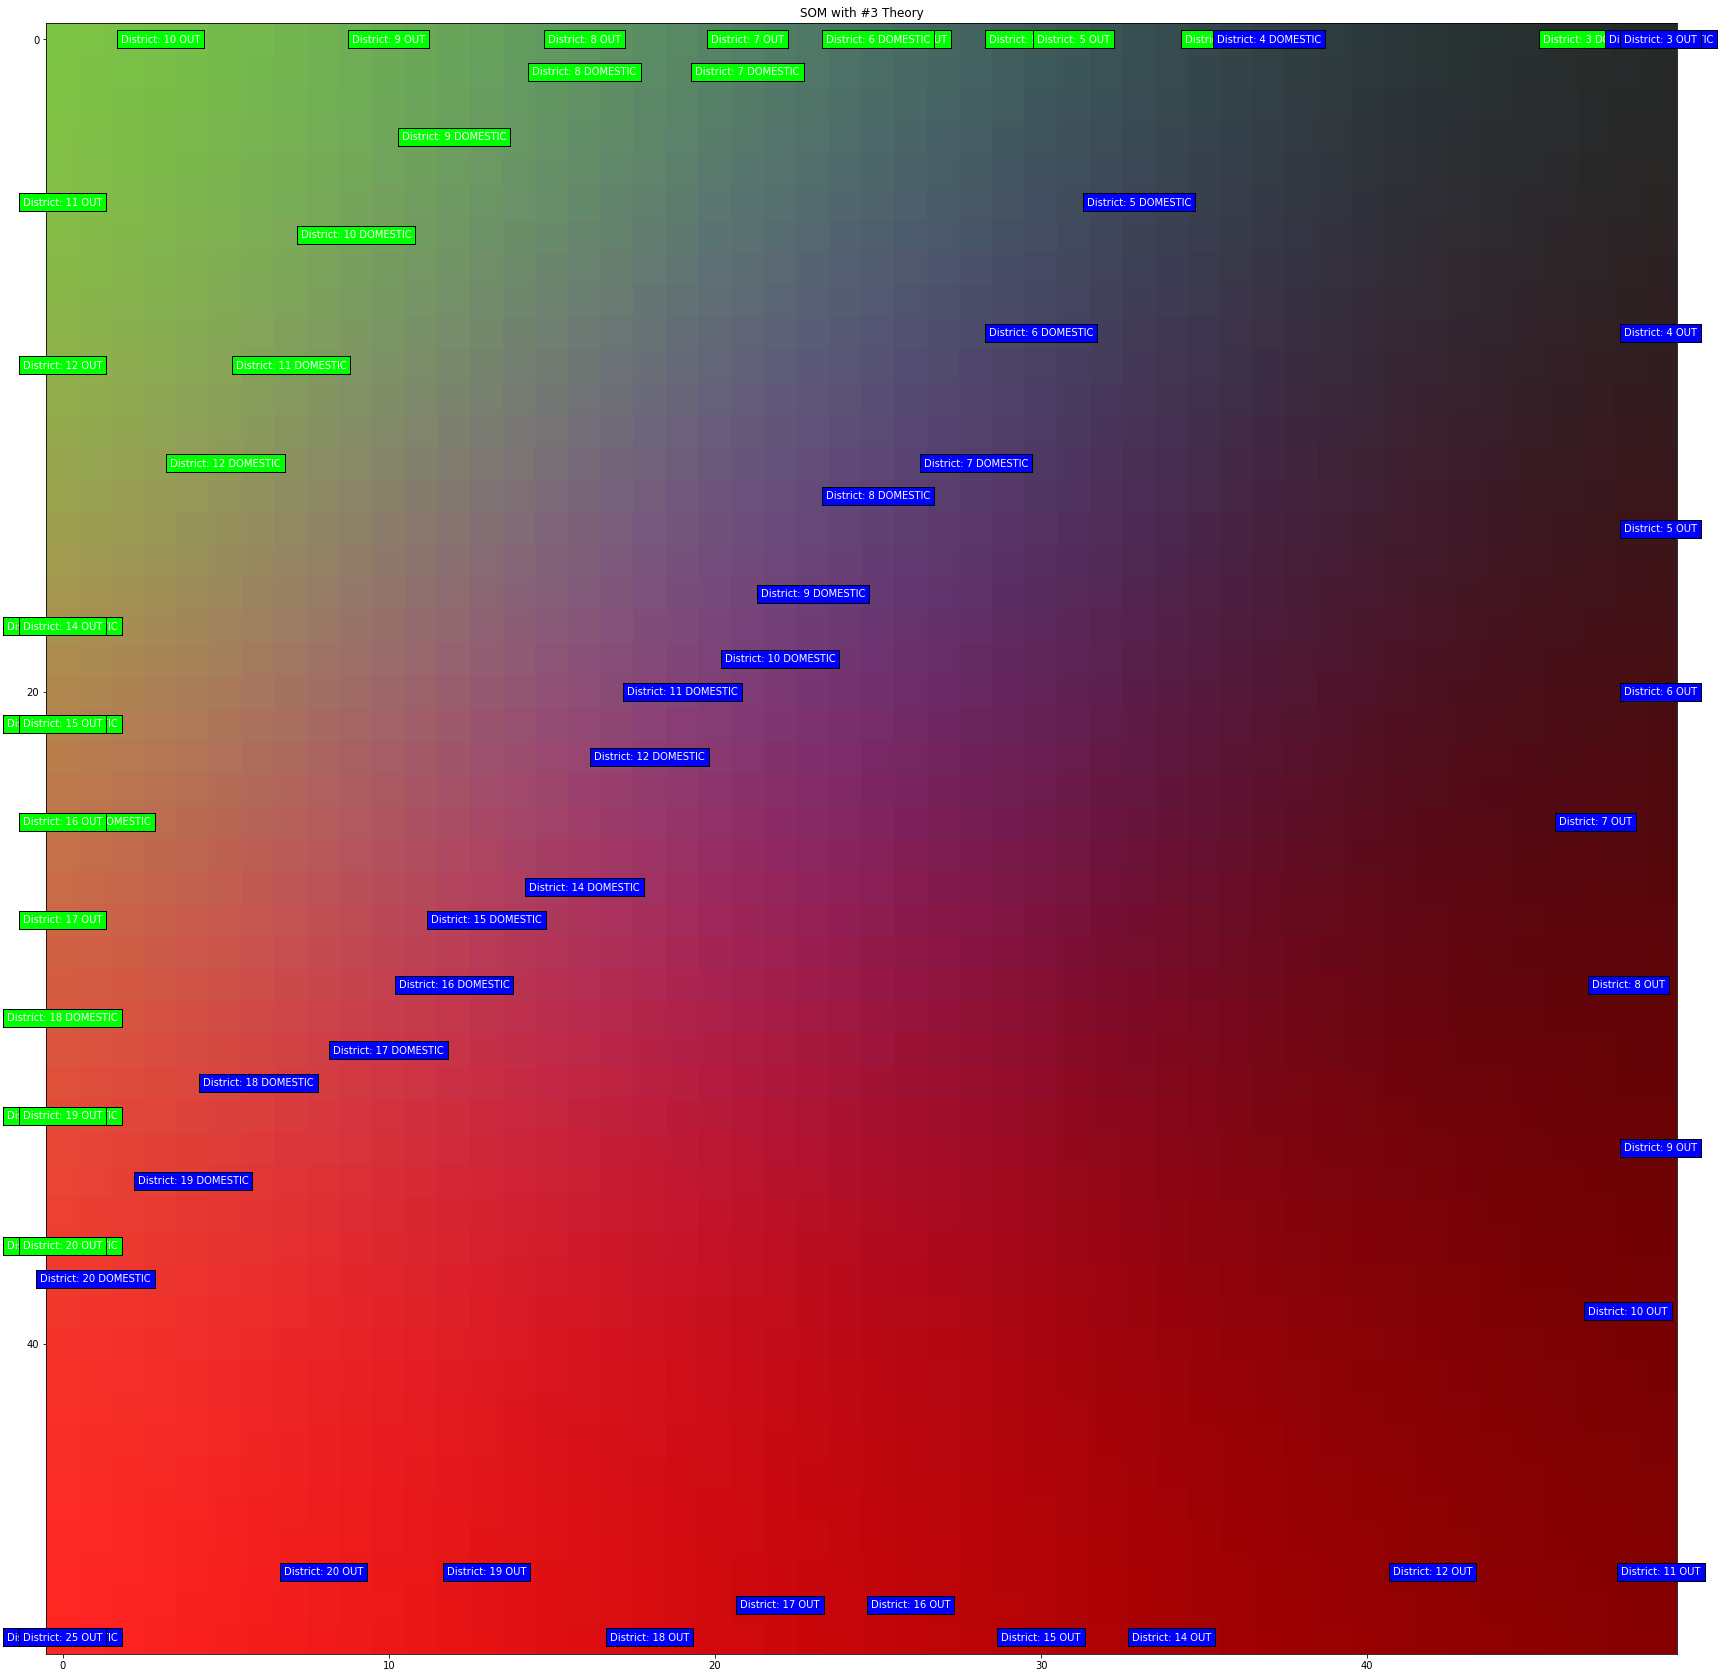

In [0]:
plt.figure(figsize=(30,30))
plt.imshow(image_grid_som3)
plt.title('SOM with #3 Theory')
for i, c in enumerate(mapped):
  msg = "District: " + str(predict_values.iloc[i][0])
  if predict_values.iloc[i][-1] == False:
     msg = msg + ' OUT'
  else:
     msg = msg + ' DOMESTIC'
  if predict_values.iloc[i][1] == False:
     border = dict(facecolor=(0, 0, 1), alpha=1, lw=1)
  else:
     border = dict(facecolor=(0, 1, 0), alpha=1, lw=1)
  plt.text(c[1], c[0], msg, color='white', ha = 'center', va='center', bbox=border)

plt.show()

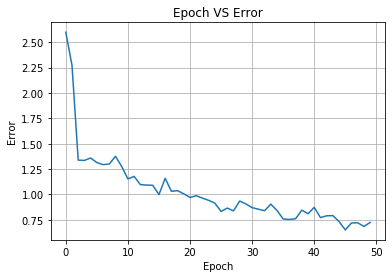

In [0]:
  plt.figure('Error Progress')
  plt.plot(list(range(0, crime_som3.epochs)), crime_som3.errors)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.grid(True)
  plt.title('Epoch VS Error')
  plt.show()

### Conclusión de la Hipótesis

En este apartado hemos querido hacer un acercamiento básico al uso del mapa *SOM* con los **datos de la criminalidad de Chicago.** Hemos querido comprobar si efectivamente el *SOM* clusterizaba bien los datos eligiendo tres variables bastante simples para agrupar: **Distrito, Arresto y Doméstico.**

- Como se puede observar el ***SOM* realiza correctamente la clusterizacion de datos mediante un entrenamiento NO supervisado.** En este caso, aparecen 4 clústers bien definidos: 
  - Casos domésticos con arresto
  - Casos no doméstico con arresto
  - Casos domésticos sin arresto
  - Casos no doméstico sin arresto

- Además, dentro de estos *clusters*, **los datos están distribuidos conforme al distrito.** Esto es, que **los distritos con numeración cercana** (distritos cercanos) **aparecen juntos en el mapa**.

Sin embargo, **no hemos encontrado un resultado del todo satisfactorio.** Si bien el mapa clasifica correctamente, está herramienta de aprendizaje automático no sirve para resolver esta pregunta.

A raíz de esta experiencia, en los siguientes estudios los resultados serán mucho más satisfactorios debido a que se reflexionará y **se hará un estudio previo más complejo de cuál es una pregunta correcta y con qué debe entrenar el *SOM*.**

## Estudio 2: 

### Hipótesis
¿Cuál es la relación entre el **tipo de crimen** y **la hora y el día de la semana en que se comete este**?

En un principio nos hemos planteado si existe una relación entre el tipo de crimen y la hora o el día de la semana en que este se comete. Por ejemplo, es lógico pensar que los crímenes nocturnos tienden a ser relacionados con prostitución o drogas mientras que los crímenes en un horario diurno podrían ser más relacionados con engaños o estafas. Además, también se puede llegar a pensar que los crímenes pueden llegar a ocurrir más los fines de semana que entre semana. Por ello, se ha reflexionado sobre esta hipótesis y se ha realizado un estudio con un mapa *SOM*.

Para ello, se ha entrenado el *dataset* con las columnas *Hour*, *Weekday* e *IUCR*. 

In [0]:
hipotesis1 = dataset[['Hour','Weekday','IUCR']]
hipotesis1

,Hour,Weekday,IUCR
0,0,6,113
1,2,6,83
2,19,6,244
3,12,6,77
4,17,6,133
...,...,...,...
176644,12,5,0
176645,18,4,0
176646,18,0,0
176647,11,0,0


In [0]:
crime_som1 = SOM(50, 50, hipotesis1.shape[1], learning_rate=0.85, epochs=50)
crime_som1.train(hipotesis1.to_numpy(), size_per_epoch = 500)

Iteracion 49: SSE: 8.552984			

In [0]:
randomize = np.arange(len(hipotesis1))
np.random.shuffle(randomize)
predict_values = hipotesis1.iloc[randomize[:7000]]
mapped = crime_som1.predict(predict_values.to_numpy())
clusters = np.abs(crime_som1.get_clusters())
max0, max1, max2 = 1, 1, 1
for i in range(len(clusters)):
  for j in range(len(clusters[i])):
    max0 = clusters[i][j][0] if clusters[i][j][0] > max0 else max0
    max1 = clusters[i][j][1] if clusters[i][j][1] > max1 else max1
    max2 = clusters[i][j][2] if clusters[i][j][2] > max2 else max2

image_grid_som1 = np.divide(clusters,[max0, max1, max2])

Como se verá a lo largo de los tres estudios, **el color de fondo del *SOM* es el resultado en RGB de los pesos de las neuronas** (que dependen del entrenamiento de los distintos valores que se introdujeron en el *input*). Además, **la dimensionalidad de este estudio coincide con la cantidad de colores con las que se realiza una codificación RGB.**

Con esta codificación se pretende visualizar que **los pesos de las neuronas tengan una cierta conexión entre sí y no se produzcan saltos grandes entre sus pesos** cuando se trata de neuronas cercanas.

En este caso además, entre más claro sea el color de las etiquetas, mayor es la hora (19-23) y entre más oscuro, menor es la hora (0-4).

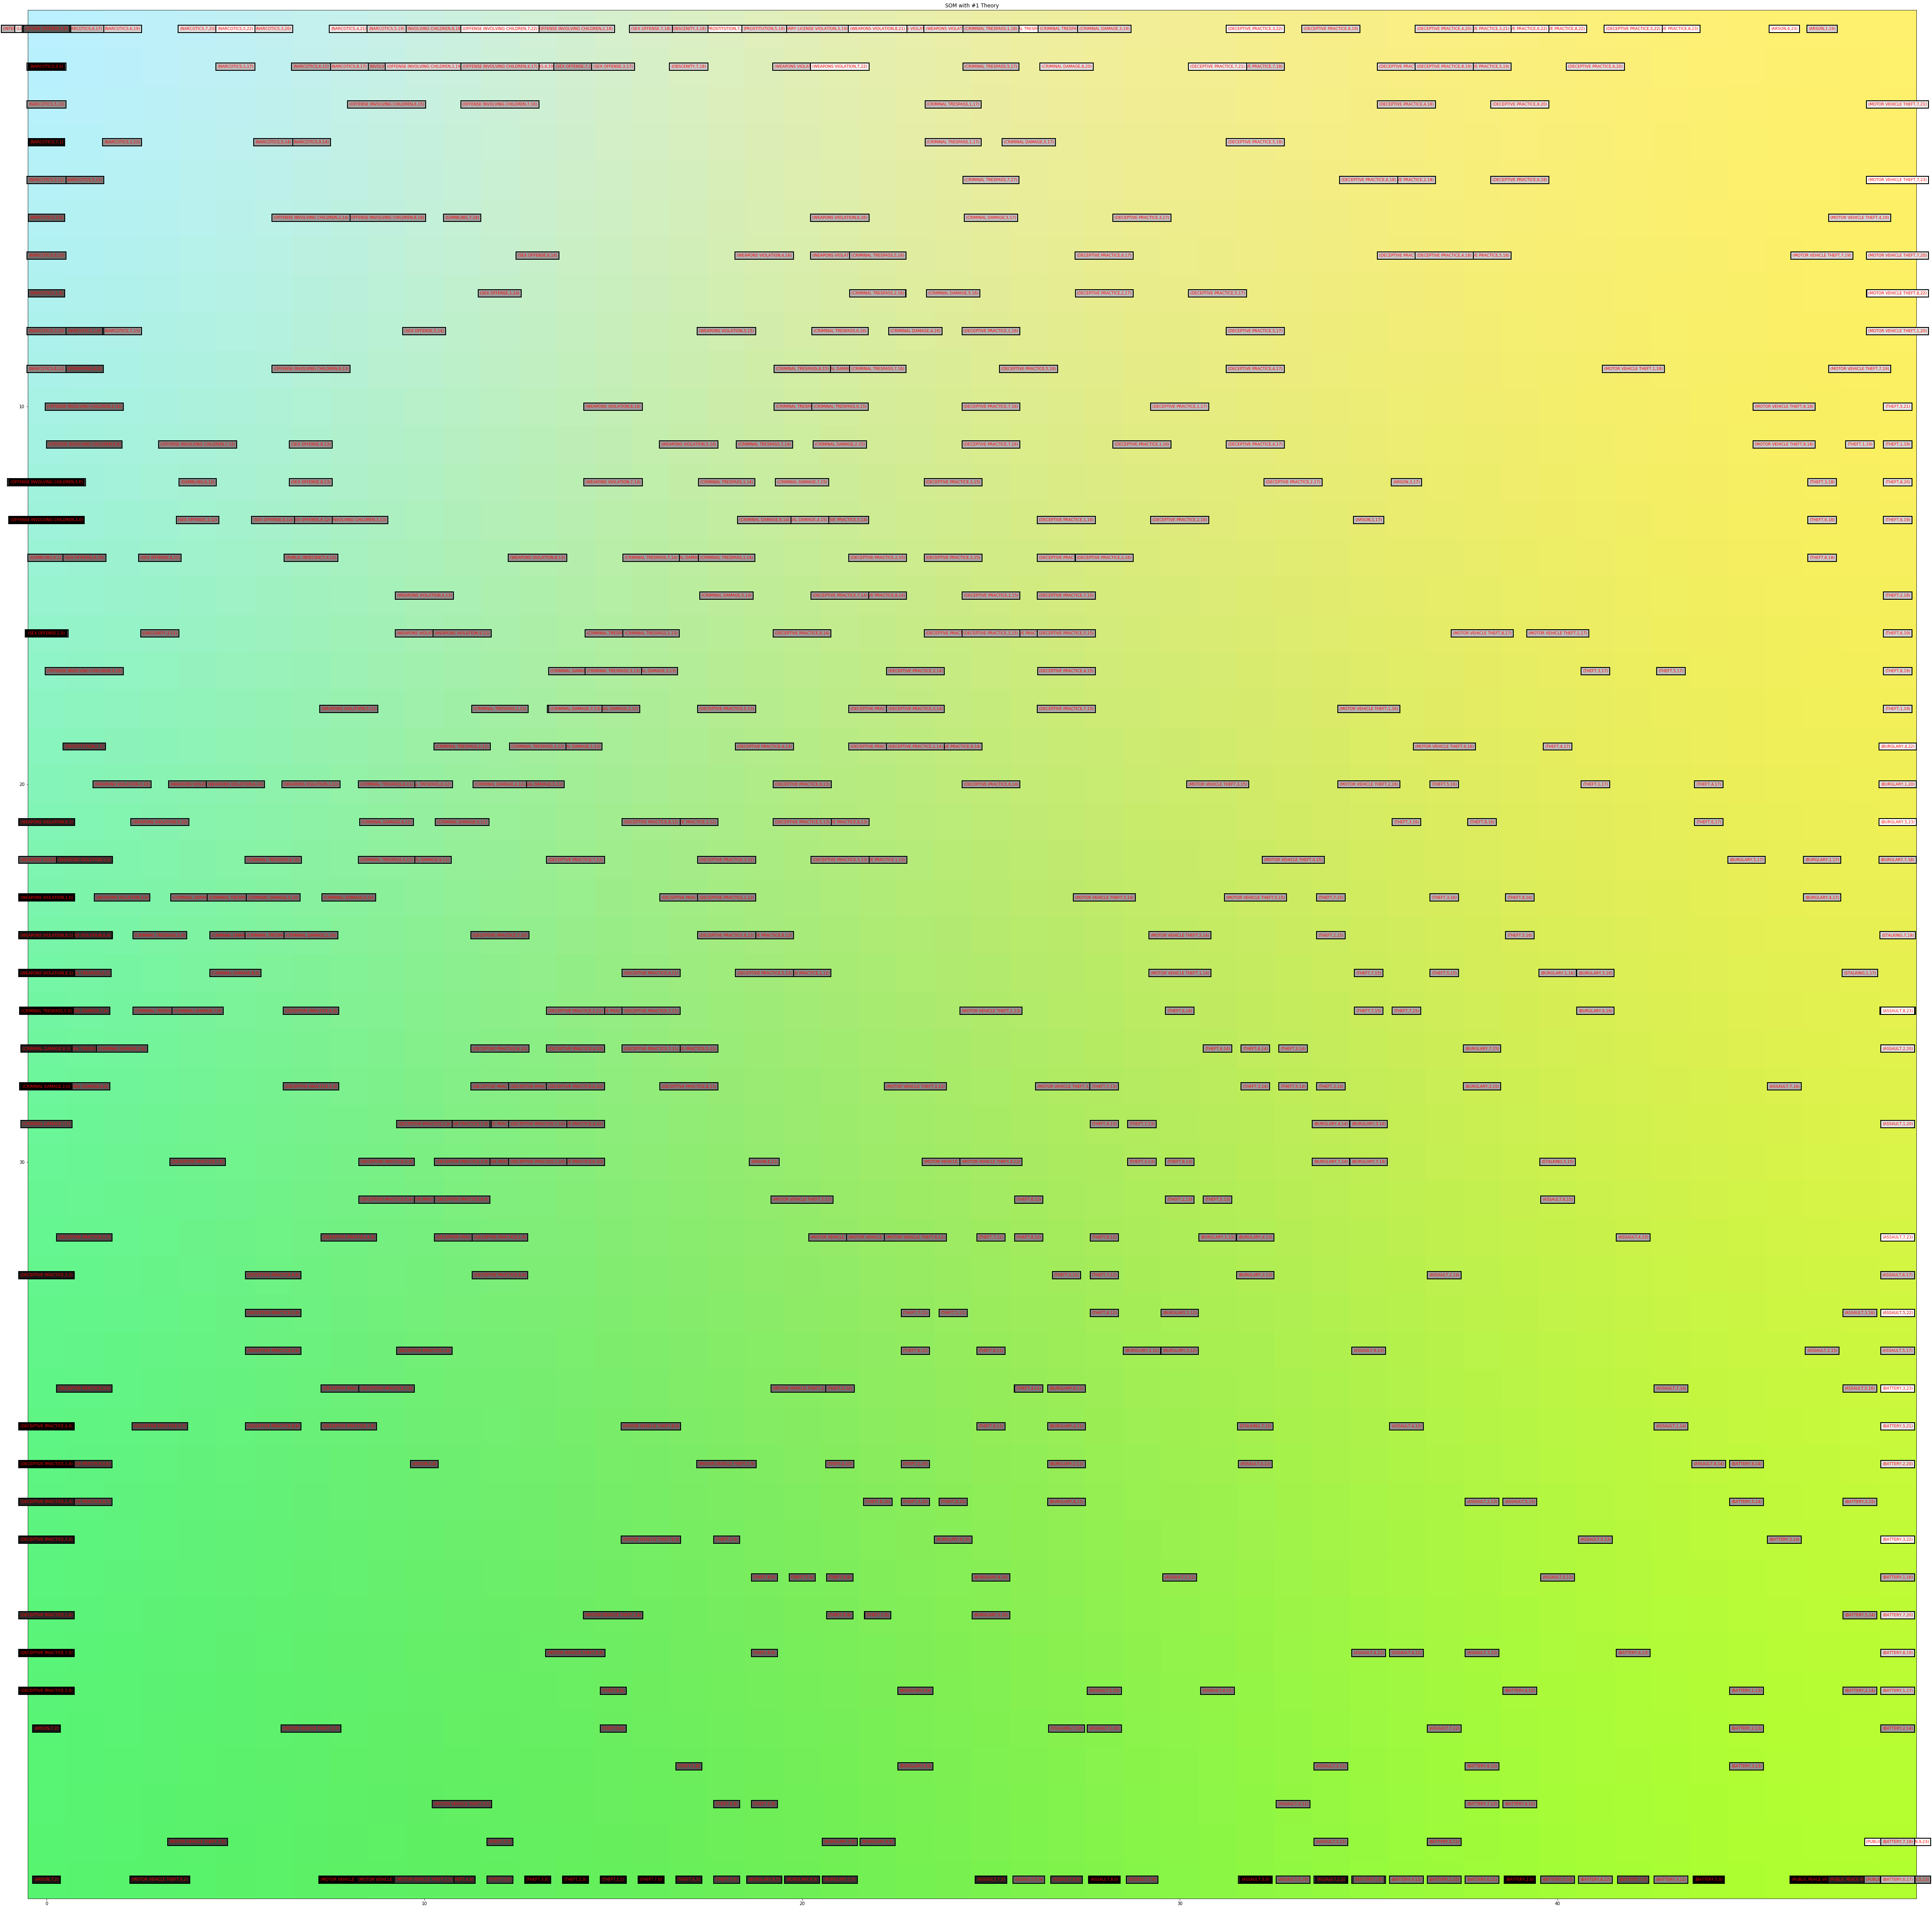

In [0]:
plt.figure(figsize=(80,80))
plt.imshow(image_grid_som1)
plt.title('SOM with #1 Theory')
for i, c in enumerate(mapped):
  color = predict_values.iloc[i][0]/23
  plt.text(c[1], c[0], "(" + original_dataset.iloc[randomize[i]]['Primary Type'] + "," + str(dataset.iloc[randomize[i]]['Month']) + "," + str(dataset.iloc[randomize[i]]['Hour']) + ")", size=9, color='red', ha = 'center', va='center', bbox=dict(facecolor=(color, color, color), alpha=1, lw=2))

plt.show()

Como se puede observar en el siguiente mapa, **el día de la semana no tiene mucha relevancia en la distribución del *SOM***, a pesar de que es lógico poder llegar a reflexionar que **los fines de semana se pueden producir más crímenes.**

El siguiente mapa **está compuesto por puntos que representan el día de la semana del crimen.** Entre más **claro** se dibuje dicho punto, **más próximo al fin de semana** estará el crimen. Entre más **oscuro**, **más próximo al inicio de la semana.** Como se puede ver, no se producen agrupaciones.

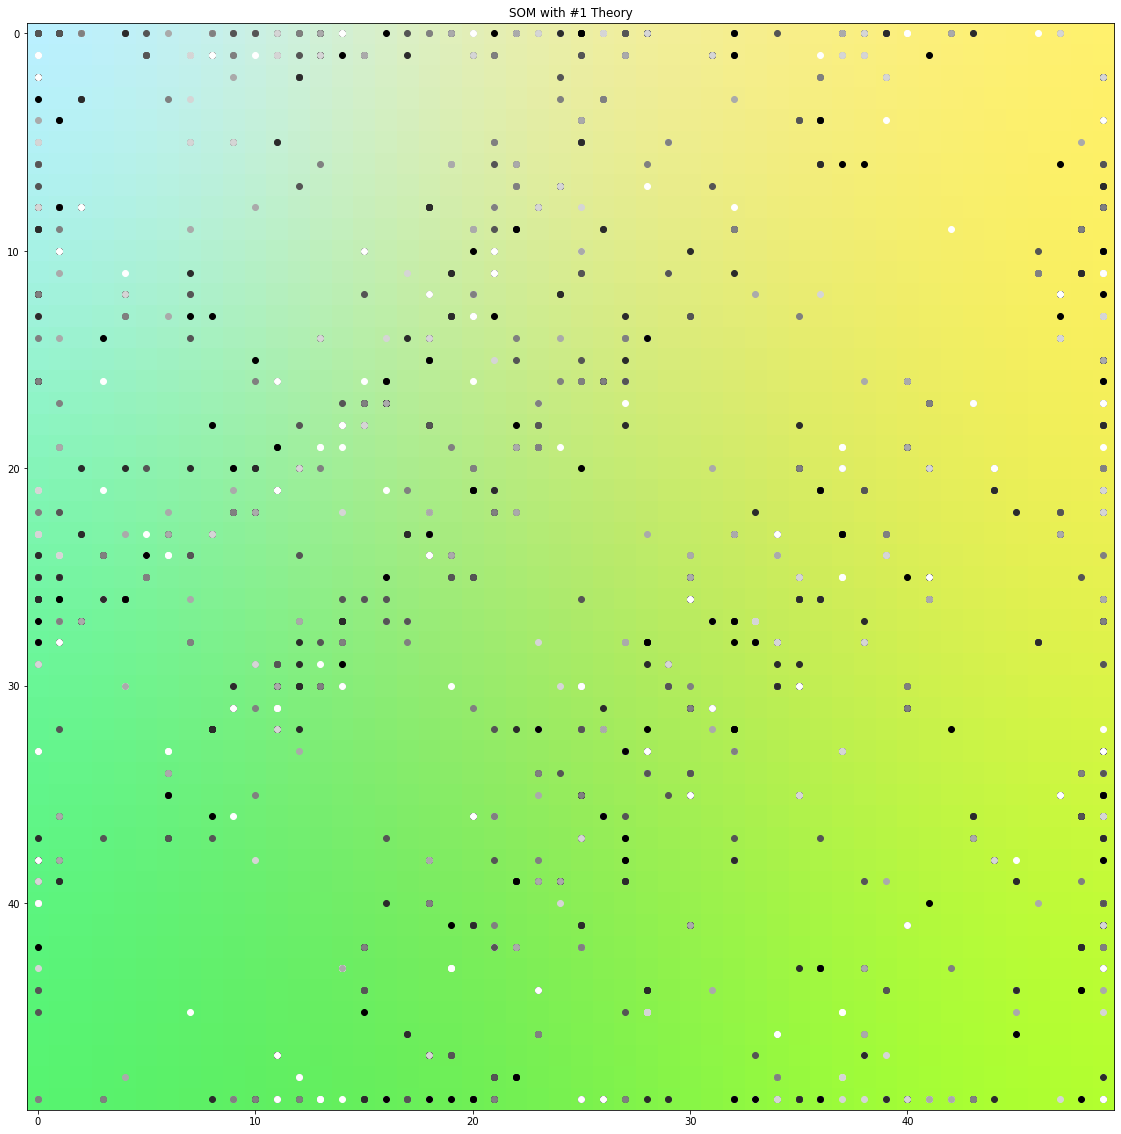

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(image_grid_som1)
plt.title('SOM with #1 Theory')
for i, c in enumerate(mapped):
  color = predict_values.iloc[i][1]/6
  plt.scatter(c[1], c[0], color=(color, color, color), alpha=1)

plt.show()

### Evolución del Error por *Epochs*


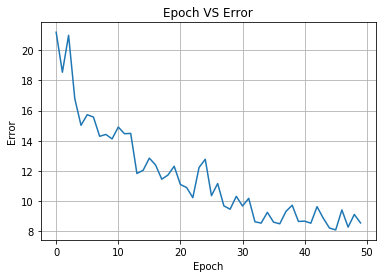

In [0]:
  plt.figure('Error Progress')
  plt.plot(list(range(0, crime_som1.epochs)), crime_som1.errors)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.grid(True)
  plt.title('Epoch VS Error')
  plt.show()

**Como se puede observar, el porcentaje de crímenes nocturnos relacionados a *Narcotics*, *Sex* y *Assault* es mayor cuando es de noche en Chicago:**

In [0]:
max_hour = 7
min_hour = 17

narcotics_cat = np.array(dataset.iloc[(original_dataset.loc[(original_dataset['Primary Type'] == 'NARCOTICS') | (original_dataset['Primary Type'] == 'GAMBLING') | (original_dataset['Primary Type'] == 'KIDNAPPING') | (original_dataset['Primary Type'] == 'OFFENSE INVOLVING CHILDREN') | (original_dataset['Primary Type'] == 'GAMBLING')].index.tolist())]['Hour'])
narcotics_cat_percentage = round(np.array(np.where((narcotics_cat <= max_hour) | (narcotics_cat >= min_hour))).shape[1]*100/(len(narcotics_cat)),2)
print("Porcentaje de 'Narcotics' nocturno:", narcotics_cat_percentage, "%")

sex_cat = np.array(dataset.iloc[(original_dataset.loc[(original_dataset['Primary Type'] == 'OBSCENITY') | (original_dataset['Primary Type'] == 'PROSTITUTION') | (original_dataset['Primary Type'] == 'SEX OFFENSE')].index.tolist())]['Hour'])
sex_cat_percentage = round(np.array(np.where((sex_cat <= max_hour) | (sex_cat >= min_hour))).shape[1]*100/(len(sex_cat)),2)
print("Porcentaje de 'Sex' nocturno:", sex_cat_percentage, "%")

assault_cat = np.array(dataset.iloc[(original_dataset.loc[(original_dataset['Primary Type'] == 'ASSAULT') | (original_dataset['Primary Type'] == 'BATTERY') | (original_dataset['Primary Type'] == 'PUBLIC PEACE VIOLATION')].index.tolist())]['Hour'])
assault_cat_percentage = round(np.array(np.where((assault_cat <= max_hour) | (assault_cat >= min_hour))).shape[1]*100/(len(assault_cat)),2)
print("Porcentaje de 'Assault' nocturno:", assault_cat_percentage, "%")

Porcentaje de 'Narcotics' nocturno: 52.76 %
Porcentaje de 'Sex' nocturno: 68.97 %
Porcentaje de 'Assault' nocturno: 58.72 %


### Conclusión de la Hipótesis

Como se puede observar en una de las ejecuciones que se realizaron:

![resultado_hipotesis_1](https://drive.google.com/uc?id=1aHTD_PtwlRj5S5yd0UngCJrtF4ZF8nF0)

De la distribución se puede sacar las siguientes hipótesis:
- Hay mucha relación entre **los tipos de crímenes y las horas** en las que estos suceden.
  - Por ejemplo, **se tienen una serie de grupos principales** (los cuales están formados de ese tipo de crimen y similares).
    - En este caso, se puede observar cómo ***Theft*, *Deceptive practices* y *Criminal damage* tienen presencia a lo largo de sus respectivas secciones**, habiendo tanto etiquetas más oscuras como etiquetas más claras, dado a que se realizan a lo largo de todo el día (se recuerda que en este caso el color de las etiquetas vuelve a simbolizar la hora en la que se realiza la actividad, siendo las más claras y más oscuras las que se realizan de manera nocturna. Es decir, de las 19h-04h aproximadamente).
    - Mientras que, en el caso de ***Sex*** (que incluye entre otros *obscenity*, *prostitution* y *sex offense*), ***Narcotics, Gambling, Kindnapping, Offense Involving Children* y *Assault*, se realizan a unas horas más nocturnas** (debido al color de sus etiquetas y a la distribución en el *SOM*, que introduce pocas de ellas en los lugares no cercanos a los bordes de la sección, donde se encuentran las más nocturnas).
- Como ya se mencionó, **apenas tiene importancia el día de la semana en la distribución.**
- Se puede estudiar como **los códigos *IUCR* cercanos dan lugar a una posición cercana en el *SOM***. Por ejemplo, *theft*, *motor vehicle theft* y *burglary* van a parar a **la misma sección del *SOM***.


## Estudio 3:

### Hipótesis
**¿Cual es la relación entre la Latitud/longitud y si el crimen terminó en arresto?**

Con esta pregunta queremos conocer en qué zonas se producen un mayor número de arrestos (se resuelve el crimen), dado a que sabiendo en qué zonas se resuelve el crimen más eficazmente podemos realizar varias hipótesis.

Por lo tanto, para esta hipótesis trabajaremos con las siguientes columnas del dataset: *Latitude*, *Longitude*, *Arrest*. Además, hemos notado que como los valores de latitud y longitud tienen variaciones de decimales, el *SOM* apenas los tendrá en cuenta a la hora de agrupar y su principal forma de agrupación será basada en si hubo un arresto o no.  Por ello, para solucionar dicho problema multiplicamos tanto la longitud como la latitud por 100 para que la diferencia sea más notoria y perceptible.


In [0]:
hipotesis2 = dataset[['Latitude','Longitude','Arrest']].copy()
hipotesis2['Latitude'] = hipotesis2['Latitude']*100
hipotesis2['Longitude'] = hipotesis2['Longitude']*100
hipotesis2

,Latitude,Longitude,Arrest
0,4175.426822,-8771.938811,False
1,4169.797624,-8762.933308,False
2,4181.307077,-8769.680265,False
3,4176.732864,-8757.388760,False
4,4194.952100,-8778.641151,False
...,...,...,...
176644,4178.289015,-8758.877343,False
176645,4188.732203,-8775.868972,False
176646,4180.816800,-8763.333646,False
176647,4192.972657,-8764.092074,False


In [0]:
crime_som2 = SOM(50, 50, hipotesis2.shape[1], learning_rate=0.85, epochs=50)
crime_som2.train(hipotesis2.to_numpy(), size_per_epoch = 500)

Iteracion 49: SSE: 2.225102			

In [0]:
randomize = np.arange(len(hipotesis2))
np.random.shuffle(randomize)
predict_values = hipotesis2.iloc[randomize[:7000]]
mapped = crime_som2.predict(predict_values.to_numpy())
clusters = np.abs(crime_som2.get_clusters())
max0, max1, max2 = 1, 1, 1
for i in range(len(clusters)):
  for j in range(len(clusters[i])):
    clusters[i][j][2] =  clusters[i][j][2] * 1000
    max0 = clusters[i][j][0] if clusters[i][j][0] > max0 else max0
    max1 = clusters[i][j][1] if clusters[i][j][1] > max1 else max1
    max2 = clusters[i][j][2] if clusters[i][j][2] > max2 else max2

image_grid_som2 = np.divide(clusters,[max0, max1, max2])

Realizamos la representación del *SOM* mostrando en <font color='red'> rojo </font> aquellos registros que tuvieron un arresto y en <font color='black'> negro </font> aquellos que no dieron lugar a un arresto. Los arrestos están representados con más grosor, siendo este el motivo por el que se pueden observar varios puntos <font color='black'>negros</font> sobre puntos <font color='red'>rojos</font>.

Además, se puede observar en el mismo fondo que los pesos del *SOM* son mayores (color más claro) cuando existen arrestos.

  - Se debe mencionar que el color de fondo es el resultado de los pesos (latitud, longitud, arresto) en un rango de RGB.

  - El *SOM* ha realizado los agrupamientos teniendo en cuenta la latitud, la longitud y el arresto.

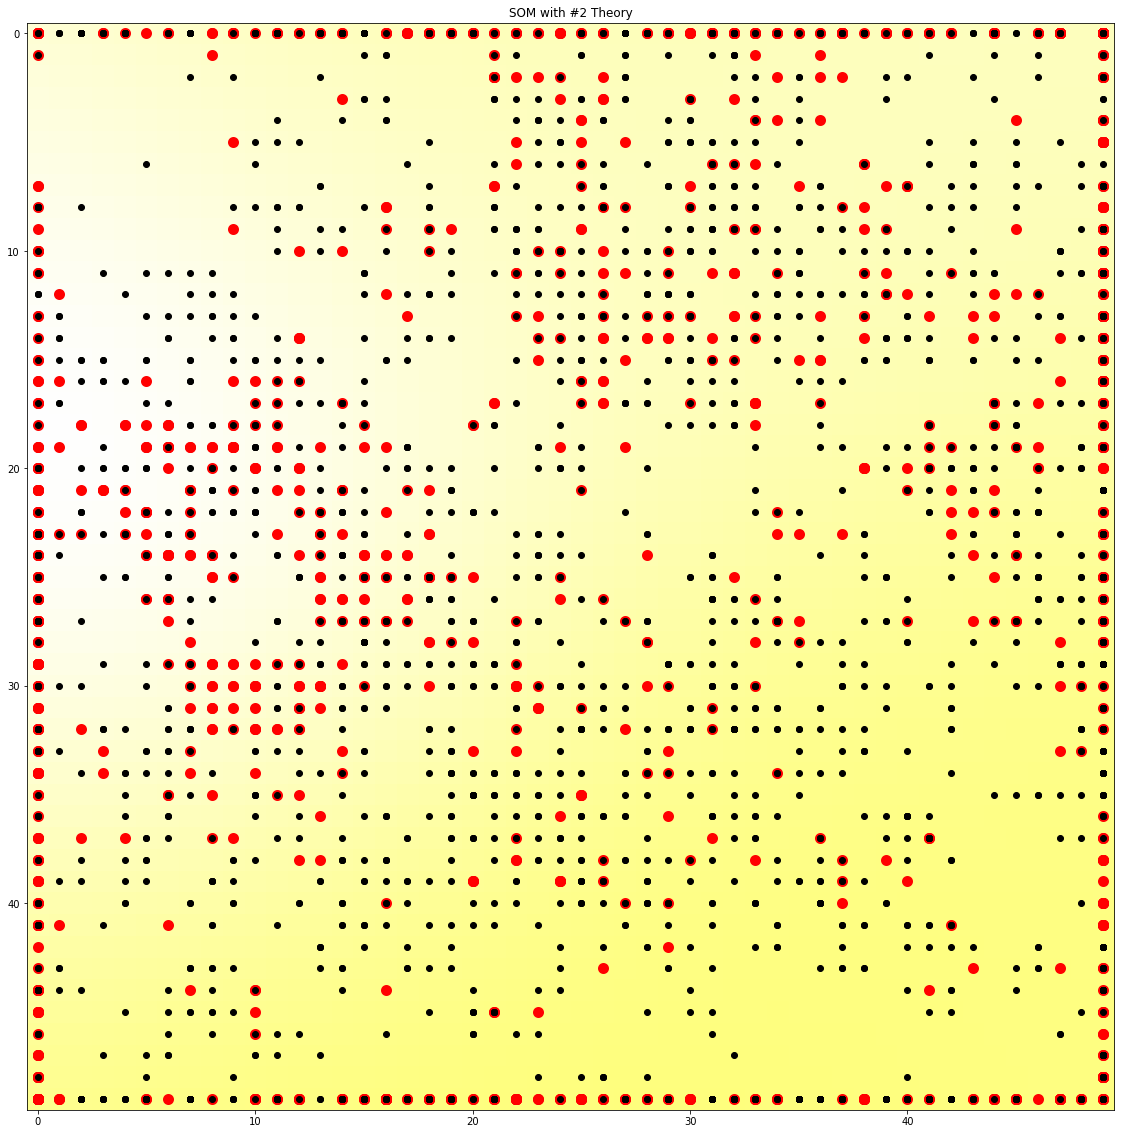

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(image_grid_som2)
plt.title('SOM with #2 Theory')
for i, c in enumerate(mapped):
  if predict_values.iloc[i][2] == False:
     plt.scatter(c[1], c[0], color='black', alpha=1)
  else:
     plt.scatter(c[1], c[0], color='red', linewidths=5)

plt.show()


Realizamos el mismo *plot* pero mostrando las coordenadas:

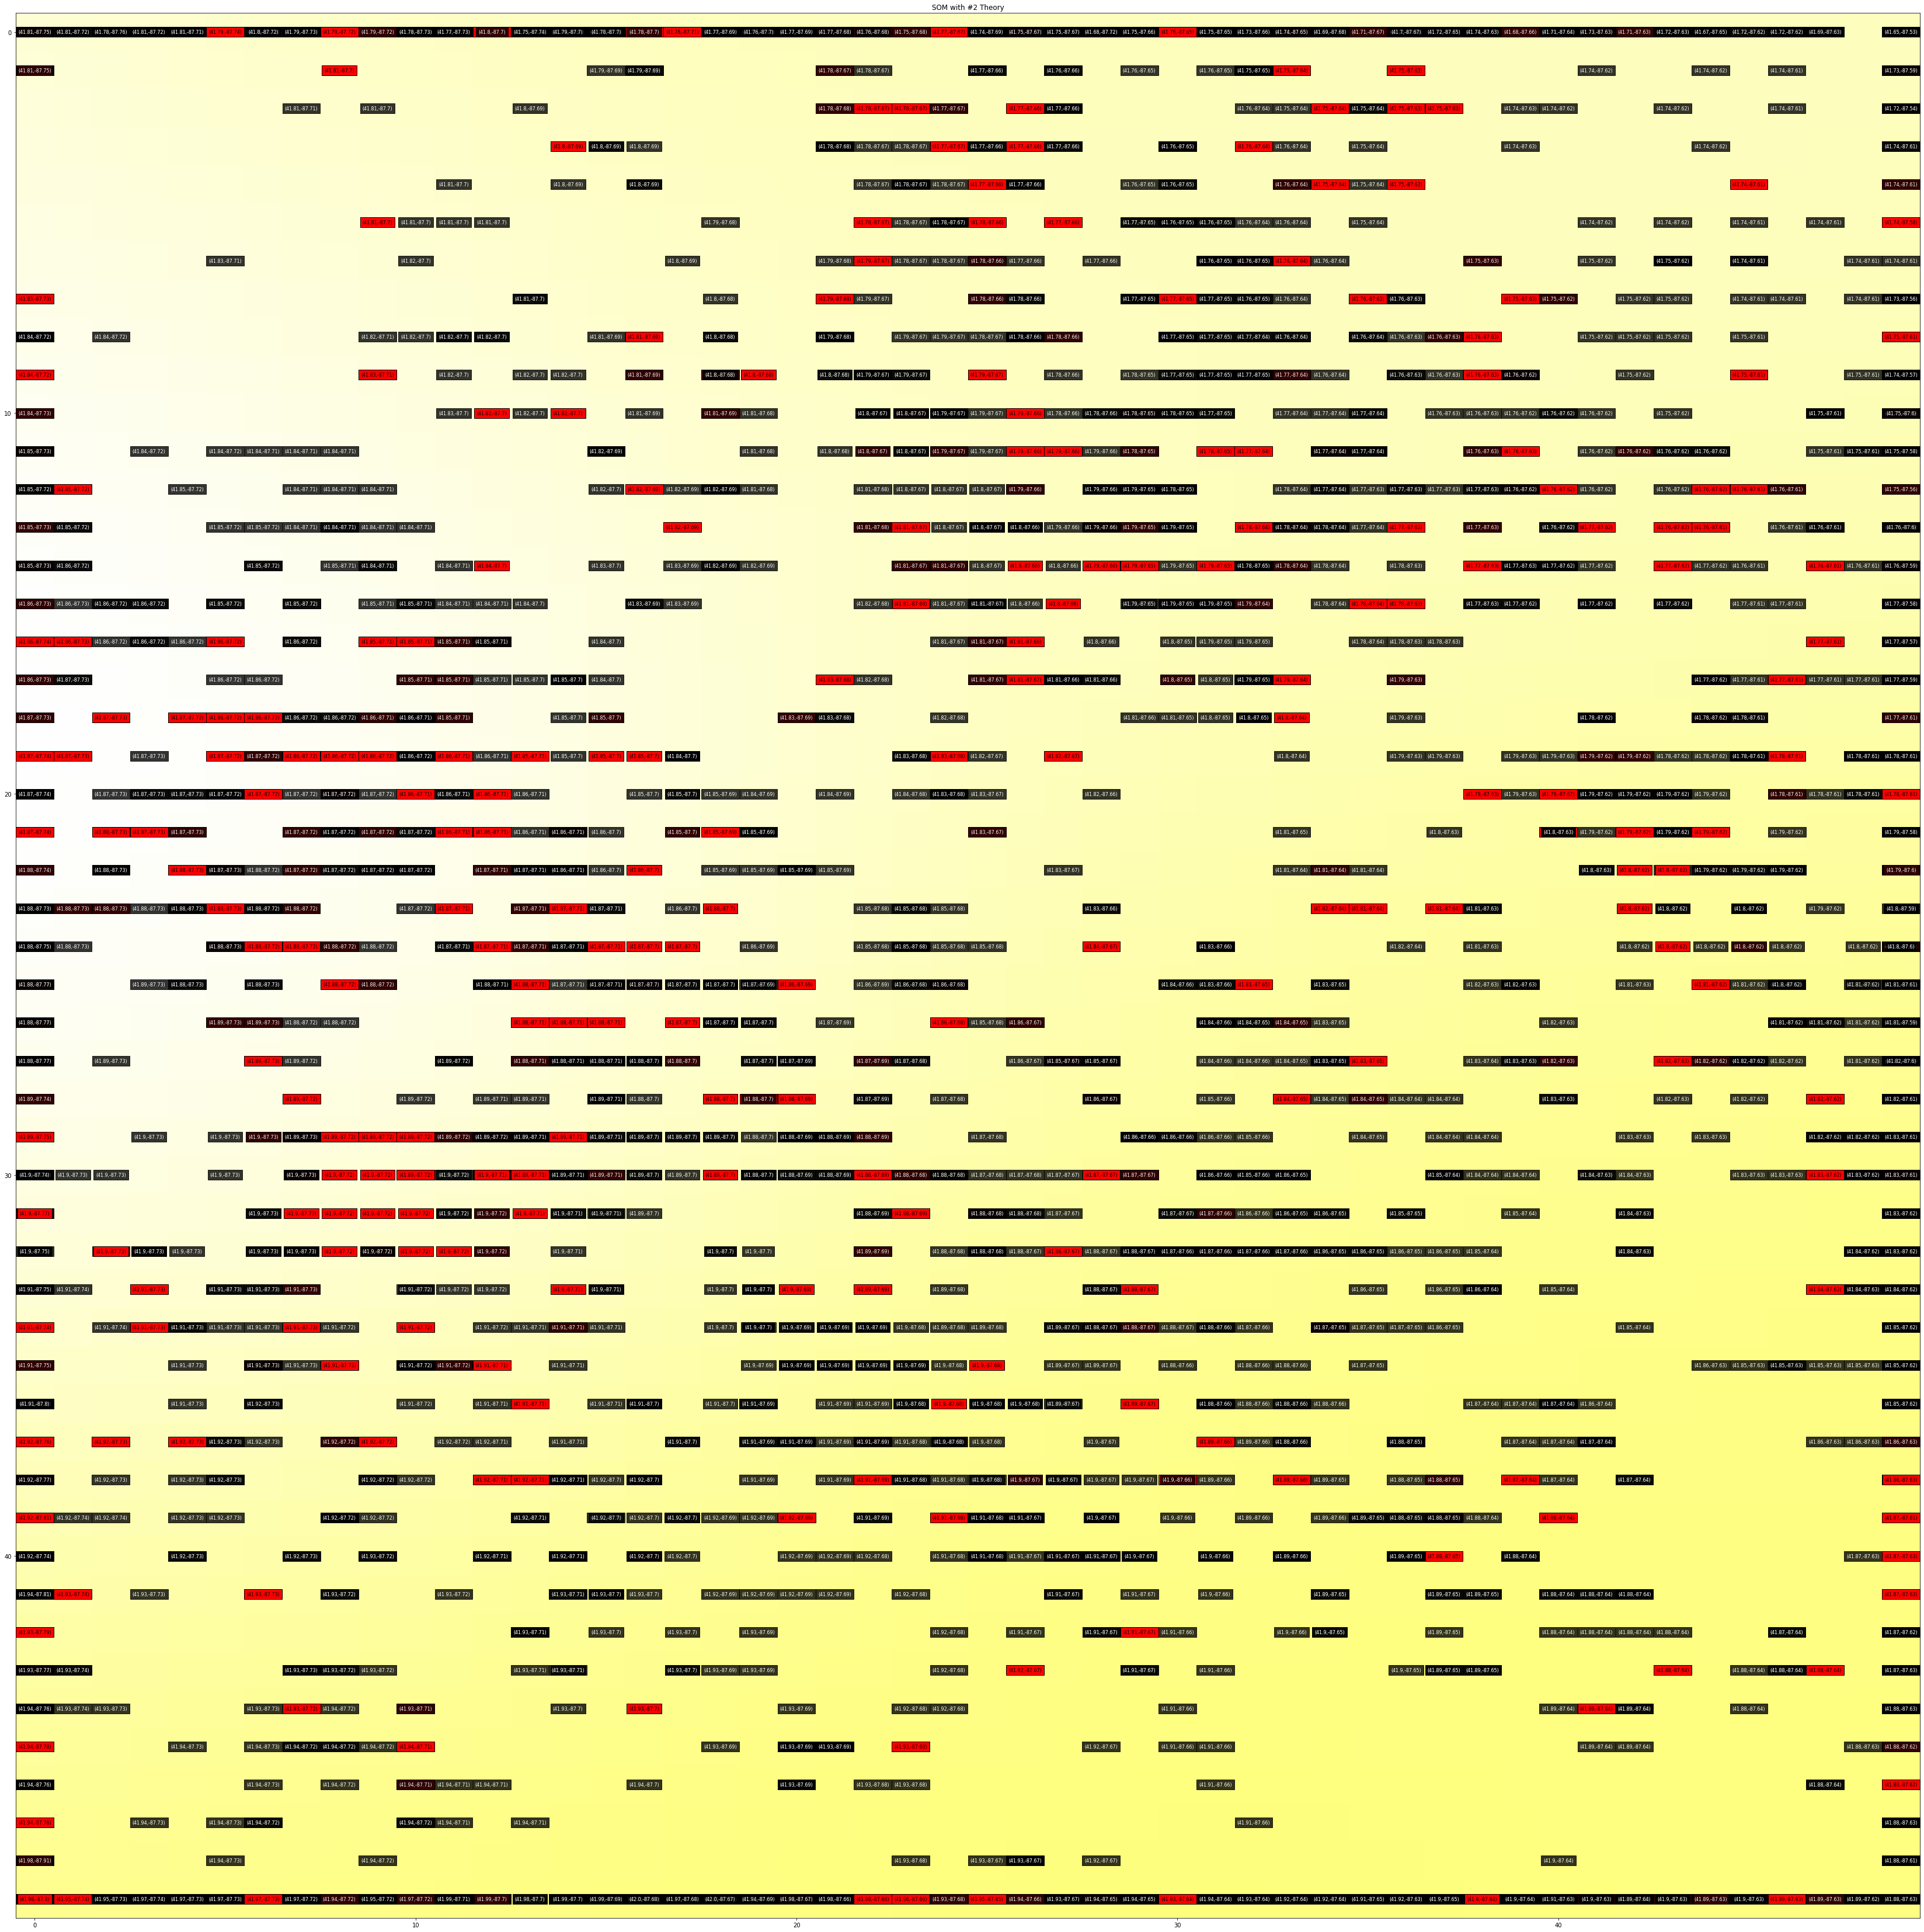

In [0]:
plt.figure(figsize=(60,60))
plt.imshow(image_grid_som2)
plt.title('SOM with #2 Theory')
for i, c in enumerate(mapped):
  if predict_values.iloc[i][2] == False:
     plt.text(c[1], c[0], "("+ str(round(predict_values.iloc[i][0]/100, 2)) + "," + str(round(predict_values.iloc[i][1]/100, 2)) + ")" , size=8, color='white', ha = 'center', va='center', bbox=dict(facecolor=(0, 0, 0), alpha=0.8, lw=1))
  else:
     plt.text(c[1], c[0], "("+ str(round(predict_values.iloc[i][0]/100, 2)) + "," + str(round(predict_values.iloc[i][1]/100, 2)) + ")", size=8, color='black', ha = 'center', va='center', bbox=dict(facecolor=(1, 0, 0), alpha=1, lw=1))
plt.show()

### Evolución del Error por *Epochs*

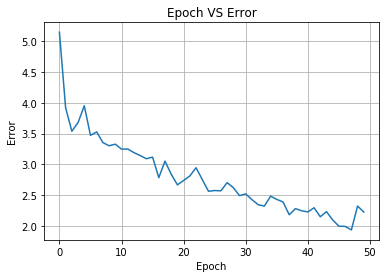

In [0]:
  plt.figure('Error Progress')
  plt.plot(list(range(0, crime_som2.epochs)), crime_som2.errors)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.grid(True)
  plt.title('Epoch VS Error')
  plt.show()

In [0]:
arrested_rows_total = original_dataset.Arrest.value_counts()
print("Total Arrested Rows: ", round(arrested_rows_total[1]*100/(arrested_rows_total[0]+arrested_rows_total[1]), 2), "%\n")

arrested_rows_area1 = original_dataset[(original_dataset["Latitude"] >= 41.82) & (original_dataset["Latitude"] <= 41.91) &
                 (original_dataset["Longitude"] <= -87.68) & (original_dataset["Longitude"] >= -87.75)].Arrest.value_counts()

print("Arrested Rows Percentage in #1 Area: ", round(arrested_rows_area1[1]*100/(arrested_rows_area1[0]+arrested_rows_area1[1]), 2), "% [Total Rows: ", arrested_rows_area1[0]+arrested_rows_area1[1], "]")
print("Arrested Rows Percentage in #1 Area in relation to total dataset: ", round(arrested_rows_area1[1]*100/arrested_rows_total[1], 2), "%\n")

arrested_rows_area2 = original_dataset[(original_dataset["Latitude"] >= 41.74) & (original_dataset["Latitude"] <= 41.83) &
                 (original_dataset["Longitude"] <= -87.62) & (original_dataset["Longitude"] >= -87.68)].Arrest.value_counts()

print("Arrested Rows Percentage in #2 Area: ", round(arrested_rows_area2[1]*100/(arrested_rows_area2[0]+arrested_rows_area2[1]), 2), "% [Total Rows: ", arrested_rows_area2[0]+arrested_rows_area2[1], "]")
print("Arrested Rows Percentage in #2 Area in relation to total dataset: ", round(arrested_rows_area2[1]*100/arrested_rows_total[1], 2), "%\n")

print("Arrested Rows in both areas: ", round(arrested_rows_area1[1]*100/arrested_rows_total[1], 2) + round(arrested_rows_area2[1]*100/arrested_rows_total[1], 2), "%\n")

arrested_rows_area3 = original_dataset[(original_dataset["Latitude"] >= 41.84) & (original_dataset["Latitude"] <= 41.92) &
                 (original_dataset["Longitude"] <= -87.63) & (original_dataset["Longitude"] >= -87.67)].Arrest.value_counts()

print("Arrested Rows Percentage in #3 Area: ", round(arrested_rows_area3[1]*100/(arrested_rows_area3[0]+arrested_rows_area3[1]), 2), "%")

Total Arrested Rows:  19.56 %

Arrested Rows Percentage in #1 Area:  31.47 % [Total Rows:  27661 ]
Arrested Rows Percentage in #1 Area in relation to total dataset:  25.19 %

Arrested Rows Percentage in #2 Area:  23.12 % [Total Rows:  21432 ]
Arrested Rows Percentage in #2 Area in relation to total dataset:  14.34 %

Arrested Rows in both areas:  39.53 %

Arrested Rows Percentage in #3 Area:  12.41 %


### Conclusión de la Hipótesis

Como se puede observar en una de las ejecuciones que se realizaron:

![texto alternativo](https://drive.google.com/uc?id=1vU4tjq8BQ8sYTUImpu3rvQzU_eysycvN)

De la distribución se puede sacar **las siguientes conclusiones**:
- El **porcentaje de crímenes con arresto con respecto al total del *dataset*** es un **19.56 %**.
- Se puede recoger que existen **dos principales áreas donde hay un mayor índice de arresto que en el resto de la distribución.**
  - Gracias a la distribución que ha generado el *SOM* teniendo en cuenta las 3 entradas explicadas (latitud, longitud y arresto), se pueden encontrar áreas con unas coordenadas similares entre sí. Estas **dos principales áreas** se encuentran en **los rangos de coordenadas siguientes:**
    - **Área #1: (41.82,-87.75) -> (41.91,-87.68)**
    - **Área #2: (41.74,-87.68) -> (41.83,-87.62)**
- Como se puede observar en el código descrito previamente, **el porcentaje de crímenes con arresto en esas áreas es el siguiente:**
  - **Área #1: 31.47 % (Un 25.19 % del total)**
  - **Área #2: 23.12 % (Un 14.34 % del total)**
- Si estudiamos **otro rango de coordenadas**, podemos observar el porcentaje de arrestos de estos registros y cómo dieron lugar a menos respecto al resto:
  - **Área #3: (41.84,-87.67) -> (41.92,-87.63)**
  - **Porcentaje de crímenes con arresto: 12.41 %**
  - **Como se puede observar, es un porcentaje mucho menor que en el área #1 y #2.**
- Con ello, tenemos que el *SOM* nos indica cómo un **39.53 %** de los **crímenes con arresto de Chicago suceden en estas dos áreas.**

Otro aspecto importante a comentar también es que, se puede observar que en las zonas donde hay una mayor cantidad de crímenes con arresto, el fondo es más **blanco**. Por lo tanto, a mayor color <font color='yellow'>amarillo</font>, menor es el número de arrestos.


![texto alternativo](https://drive.google.com/uc?id=1pbiYxXJ4PPHKFr212PokRS79tQVKT2M1)




## Conclusiones Generales

En esta práctica hemos estado en contacto por primera vez con **una herramienta que es distinta de las redes neuronales clásicas** que conocíamos hasta ahora. Esta herramienta es el ***SOM* con aprendizaje no supervisado** y se basa en una estrategia de aprendizaje característica de los seres humanos, siendo esta **la capacidad de clusterización o agrupamiento de conceptos en base a la similitud de sus características.** Por ello, es bastante útil para la **visualización de datos**, que es el objetivo de esta práctica. 

Con respecto a las 3 cuestiones que hemos planteado, el ***SOM*** nos ha enseñado que es una excelente forma de **visualizar la relación entre diversas características de los datos de entrada.** Sin embargo, para lograr desatar el potencial de esta gran herramienta, se requiere hacer un **buen análisis inicial de los datos** con los que alimentaremos nuestro mapa, pues esto determinará **la calidad** con la que este agrupe características.

Por ello, en esta segunda práctica **nos hemos querido centrar en el análisis preliminar de los datos.**

Para ello hemos llevado a cabo un **estudio previo y una adaptación de los datos posteriores en base a dicho estudio.** Por ejemplo, el formateo de los datos categóricos, la obtención de datos útiles a partir de los datos iniciales (como las horas o los días de la semana a partir de una fecha) o la poda del dataset.

Para la poda hemos usado además **una matriz de correlación**. Esta es una técnica muy sencilla y básica en el **análisis de datos** que nos permite ver lo relacionados que se encuentran unos datos con otros.

Con todo esto, podemos concluir que **el mapa SOM es el resultado de aplicar técnicas de inteligencia artificial a la visualización de datos** y gracias a esta actividad práctica, hemos podido **realizar respuestas a preguntas que se ubicaban en un *dataset* de dimensionalidad compleja y cuya existencia se encontraba en lo desconocido a simple vista.**

## Referencias

[1] Pablo Fernández López, [*Enunciado y Dataset*](https://cv-aep.ulpgc.es/cv/ulpgctp20/mod/folder/view.php?id=122937), ULPGC, 2019.

[2] Google, [*Google Colab*](https://colab.research.google.com/notebooks/welcome.ipynb).

[3] Google Brain, [*TensorFlow Core r1.15 Python API*](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf), tensorflow, 2019. 

[4] W. Natita, W. Wiboonsak, and S. Dusadee, [*Appropriate Learning Rate and Neighborhood Function of Self-organizing Map (SOM) for Specific Humidity Pattern
Classification over Southern Thailand*](http://www.ijmo.org/vol6/504-M08.pdf), International Journal of Modeling and Optimization, Vol. 6, No. 1, February 2016. 

[5] Achraf KHAZRI, [*Self Organizing Maps (Kohonen’s maps)*](https://towardsdatascience.com/self-organizing-maps-1b7d2a84e065), towardsdatascience, August 2019.